<a href="https://colab.research.google.com/github/dunkelweizen/DS-Unit-2-Applied-Modeling/blob/master/Copy_of_assignment_applied_modeling_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 3, Module 2*

---


# Permutation & Boosting

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] If you haven't completed assignment #1, please do so first.
- [ ] Continue to clean and explore your data. Make exploratory visualizations.
- [ ] Fit a model. Does it beat your baseline? 
- [ ] Try xgboost.
- [ ] Get your model's permutation importances.

I had to run my model locally because it was taking too long in Colab. My initial models were giving me a validation accuracy of around 21-22% which isn't great but is better than baseline. With XGBoost, I got a validation accuracy of around 31%. 
Since I'm using leave-one-out-cross-validation instead of a train/test/validation split, I had to fit permutation importance to my training set, which shows how important different features are to that set but does not generalize to other sets of data. 

You should try to complete an initial model today, because the rest of the week, we're making model interpretation visualizations.

But, if you aren't ready to try xgboost and permutation importances with your dataset today, that's okay. You can practice with another dataset instead. You may choose any dataset you've worked with previously.

The data subdirectory includes the Titanic dataset for classification and the NYC apartments dataset for regression. You may want to choose one of these datasets, because example solutions will be available for each.


## Reading

Top recommendations in _**bold italic:**_

#### Permutation Importances
- _**[Kaggle / Dan Becker: Machine Learning Explainability](https://www.kaggle.com/dansbecker/permutation-importance)**_
- [Christoph Molnar: Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/feature-importance.html)

#### (Default) Feature Importances
  - [Ando Saabas: Selecting good features, Part 3, Random Forests](https://blog.datadive.net/selecting-good-features-part-iii-random-forests/)
  - [Terence Parr, et al: Beware Default Random Forest Importances](https://explained.ai/rf-importance/index.html)

#### Gradient Boosting
  - [A Gentle Introduction to the Gradient Boosting Algorithm for Machine Learning](https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/)
  - _**[A Kaggle Master Explains Gradient Boosting](http://blog.kaggle.com/2017/01/23/a-kaggle-master-explains-gradient-boosting/)**_
  - [_An Introduction to Statistical Learning_](http://www-bcf.usc.edu/~gareth/ISL/ISLR%20Seventh%20Printing.pdf) Chapter 8
  - [Gradient Boosting Explained](http://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html)
  - _**[Boosting](https://www.youtube.com/watch?v=GM3CDQfQ4sw) (2.5 minute video)**_

In [2]:
# -*- coding: utf-8 -*-
"""
Created on Wed Dec  4 21:11:16 2019

@author: caino
"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE

In [3]:
#%%explore and clean data


df = pd.read_csv('https://raw.githubusercontent.com/fivethirtyeight/data/master/thanksgiving-2015/thanksgiving-2015-poll-data.csv')



df.columns = ['ID', 'Celebrate', 'Main_Dish', 'Main_Dish_Other', 'Main_Dish_Cooked', 'Main_Dish_Cooked_Other', 'Stuffing',
              'Stuffing_Other', 'Cranberry_Sauce', 'Cranberry_Sauce_Other', 'Gravy', 'Brussel_Sprouts', 'Carrots', 'Cauliflower',
              'Corn', 'Cornbread', 'Fruit_Salad', 'Green_Beans', 'Mac_and_Cheese', 'Mashed_Potatoes', 'Rolls_Biscuits', 'Squash',
              'Salad', 'Sweet_Potatoes', 'Side_Dish_Other1', 'Side_Dish_Other2', 'Apple_Pie', 'Buttermilk_Pie', 'Cherry_Pie', 
              'Chocolate_Pie', 'Coconut_Cream_Pie', 'Key_Lime_Pie', 'Peach_Pie', 'Pecan_Pie', 'Pumpkin_Pie', 'Sweet_Potato_Pie', 
              'No_Pie', 'Other_Pie1', 'Other_Pie2', 'Apple_Cobbler', 'Blondies', 'Brownies', 'Carrot_Cake', 'Cheesecake', 'Cookies',
              'Fudge', 'Ice_Cream', 'Peach_Cobbler', 'No_Dessert', 'Other_Dessert1', 'Other_Dessert2', 'Prayer', 'Travel_Distance', 'Parade',
              'Kids_Table_Age', 'Old_Friends', 'Friendsgiving', 'Black_Friday_Shopper', 'Retail_Worker', 'Black_Friday_Worker', 'Neighborhood_Type',
              'Age', 'Gender', 'Household_Earnings', 'US_Region']

In [4]:
#get rid of any rows where they don't celebrate
df = df.drop(df[df.Celebrate == 'No'].index)
df = df.drop('Celebrate', axis = 1)
#remove any rows where no US_Region is given

In [5]:
side_dishes = ['Stuffing',
              'Stuffing_Other', 'Cranberry_Sauce', 'Cranberry_Sauce_Other', 'Gravy', 'Brussel_Sprouts', 'Carrots', 'Cauliflower',
              'Corn', 'Cornbread', 'Fruit_Salad', 'Green_Beans', 'Mac_and_Cheese', 'Mashed_Potatoes', 'Rolls_Biscuits', 'Squash',
              'Salad', 'Sweet_Potatoes', 'Side_Dish_Other1', 'Side_Dish_Other2', 'Apple_Pie', 'Buttermilk_Pie', 'Cherry_Pie', 
              'Chocolate_Pie', 'Coconut_Cream_Pie', 'Key_Lime_Pie', 'Peach_Pie', 'Pecan_Pie', 'Pumpkin_Pie', 'Sweet_Potato_Pie', 
              'No_Pie', 'Other_Pie1', 'Other_Pie2', 'Apple_Cobbler', 'Blondies', 'Brownies', 'Carrot_Cake', 'Cheesecake', 'Cookies',
              'Fudge', 'Ice_Cream', 'Peach_Cobbler', 'No_Dessert', 'Other_Dessert1', 'Other_Dessert2']

vegetables = ['Brussel_Sprouts', 'Carrots', 'Cauliflower', 'Corn', 'Green_Beans',
              'Squash', 'Salad']
starches = ['Stuffing', 'Cornbread', 'Mac_and_Cheese', 'Mashed_Potatoes', 'Rolls_Biscuits',
            'Sweet_Potatoes']
sweet_sides = ['Cranberry_Sauce', 'Fruit_Salad']
desserts = ['Apple_Pie', 'Buttermilk_Pie', 'Cherry_Pie', 
              'Chocolate_Pie', 'Coconut_Cream_Pie', 'Key_Lime_Pie', 'Peach_Pie', 
               'Pecan_Pie', 'Pumpkin_Pie', 'Sweet_Potato_Pie',
            'Apple_Cobbler', 
               'Blondies', 'Brownies', 'Carrot_Cake', 'Cheesecake', 'Cookies',
              'Fudge', 'Ice_Cream', 'Peach_Cobbler']
pies = ['Apple_Pie', 'Buttermilk_Pie', 'Cherry_Pie', 
              'Chocolate_Pie', 'Coconut_Cream_Pie', 'Key_Lime_Pie', 'Peach_Pie', 
               'Pecan_Pie', 'Pumpkin_Pie', 'Sweet_Potato_Pie']

In [6]:
df['US_Region'].isnull().sum()

49

In [7]:
df['US_Region'] = df['US_Region'].dropna()

In [8]:
df['US_Region'].isnull().sum()

49

In [9]:
df['US_Region'].isnull().sum()

49

In [10]:
df['Main_Dish'].value_counts(normalize=True)

Turkey                    0.881930
Other (please specify)    0.035934
Ham/Pork                  0.029774
Tofurkey                  0.020534
Chicken                   0.012320
Roast beef                0.011294
I don't know              0.005133
Turducken                 0.003080
Name: Main_Dish, dtype: float64

In [11]:
df['Main_Dish_Cooked'].value_counts(normalize=True)

Baked                     0.493840
Roasted                   0.388090
Other (please specify)    0.052361
Fried                     0.048255
I don't know              0.017454
Name: Main_Dish_Cooked, dtype: float64

In [12]:
 

#%% create data wrangling function

def wrangle(df):
    df = df.dropna(subset=['US_Region'])
    #remove earnings, is creating a map of earning potential rather than anything to do with food
    df = df.drop('Household_Earnings', axis=1)
    #Simplifying the regions in order to increase model accuracy
    df['US_Region'] = df['US_Region'].apply(lambda x : 'Pacific' if ((x == 'Pacific') | (x == 'Mountain')) else x)
    df['US_Region'] = df['US_Region'].apply(lambda x : 'Northeast' if ((x == 'New England') | (x == 'Middle Atlantic')) else x)
    df['US_Region'] = df['US_Region'].apply(lambda x : 'Midwest' if ((x == 'East South Central') | (x == 'East North Central')) else x)
#removing the 'Other' side dish columns for simplicities' sake
    df = df.replace('nan', np.NaN)
    for column in df.columns:
        if 'Other' in column:
          df = df.drop(column, axis=1)
    df['Number_Vegetables'] = df[vegetables].count(axis=1)
    df['Number_Starches'] = df[starches].count(axis=1)
    df['Number_Desserts'] = df[desserts].count(axis=1)
    df['Number_Pies'] = df[pies].count(axis=1)
    #data is formatted so that a column has the name of the dish if true and NaN if false
#so replace all the NaN with No and all values with Yes
#also for Parade column
    for column in df.columns:
        if column in side_dishes:
            df[column] = df[column].apply(lambda x : 'No' if x == np.NaN else 'Yes')
        elif column == 'Parade':
            df[column] = df[column].apply(lambda x : 'No' if x == np.NaN else 'Yes')


#simplify main dish options
    main_dishes = ('Turkey', 'Ham/Pork', 'Tofurkey', 'Chicken')
    df['Main_Dish'] = df['Main_Dish'].apply(lambda x : x if x in main_dishes else 'Other')
    cook_options = ('Baked', 'Roasted', 'Fried')
    df['Main_Dish_Cooked'] = df['Main_Dish_Cooked'].apply(lambda x : x if x in cook_options else 'Other')
#remove the ID column, it's meaningless
    df = df.drop('ID', axis=1)
#remove 'Neighborhood_Type' as it is a potential data leak
    df = df.drop('Neighborhood_Type', axis=1)
#replace empty values in Black_Friday_Worker with 'No' if person isn't in retail      
    for i in range(len(df)):
        if df['Retail_Worker'].iloc[i] == 'No':
            df['Black_Friday_Worker'].iloc[i] = 'No'
#fix NaN values in other columns
    df['Kids_Table_Age'] = df['Kids_Table_Age'].fillna('No Kids Table')
    mode = df['Age'].mode()[0]
    df['Age'] = df['Age'].fillna(mode)
    mode = df['Travel_Distance'].mode()[0]
    df['Travel_Distance'] = df['Travel_Distance'].fillna(mode)
    return df

In [13]:

#%% creating X and y
def X_y_dataframes(train, test, target):
    X_train = train.drop(target, axis=1)
    X_test = test.drop(target, axis=1)
    y_train = train[target]
    y_test = test[target]
    #ordinal encoding
    encoder = OrdinalEncoder()
    X_train_encoded = encoder.fit_transform(X_train)
    X_test_encoded = encoder.fit_transform(X_test)
    #converting encoded arrays back to dataframes
    X_train_encoded = pd.DataFrame(X_train_encoded)
    X_train_encoded.columns = X_train.columns
    X_test_encoded = pd.DataFrame(X_test_encoded)
    X_test_encoded.columns = X_test.columns
    return X_train_encoded, X_test_encoded, y_train, y_test

In [14]:

#%% leave one out validation
def loocv(X_train_encoded, y_train, model):
    num_folds = 10
    num_instances = len(X_train_encoded)
    loocv = LeaveOneOut()
    results = cross_val_score(model, X_train_encoded, y_train, cv=loocv)
    print("Accuracy: %.3f%% (%.3f%%)" % (results.mean()*100.0, results.std()*100.0))


In [15]:
def select_features(X_train_encoded, y_train, num_features):
    classifier = RandomForestClassifier(n_estimators=100)
    rfe_selector = RFE(estimator=classifier, n_features_to_select=num_features, step=10, verbose=5)
    rfe_selector.fit(X_train_encoded, y_train)
    rfe_support = rfe_selector.get_support()
    rfe_feature = X_train_encoded.loc[:,rfe_support].columns.tolist()
    print(str(len(rfe_feature)), 'selected features')
    print(rfe_feature)
    return rfe_feature

In [16]:
#%%splitting data

train, test = train_test_split(df)
train = wrangle(train)
test = wrangle(test)


C:\Users\caino\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [17]:
train.head()

,Main_Dish,Main_Dish_Cooked,Stuffing,Cranberry_Sauce,Gravy,Brussel_Sprouts,Carrots,Cauliflower,Corn,Cornbread,...,Black_Friday_Shopper,Retail_Worker,Black_Friday_Worker,Age,Gender,US_Region,Number_Vegetables,Number_Starches,Number_Desserts,Number_Pies
429,Turkey,Roasted,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,...,Yes,Yes,Yes,30 - 44,Female,Northeast,3,5,2,2
490,Turkey,Roasted,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,...,No,No,No,45 - 59,Male,West South Central,2,4,2,2
365,Other,Fried,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,...,Yes,No,No,45 - 59,Female,South Atlantic,2,4,4,2
66,Turkey,Baked,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,...,No,No,No,30 - 44,Male,Pacific,2,5,2,2
595,Ham/Pork,Other,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,...,No,No,No,45 - 59,Male,Pacific,2,4,2,2


In [18]:
#%%
target = 'US_Region'
X_train_encoded, X_test_encoded, y_train, y_test = X_y_dataframes(train, test, target)

In [19]:
#%%Baseline model
print(y_train.value_counts(normalize=True))
baseline = 'South Atlantic'

South Atlantic        0.229018
Midwest               0.219061
Northeast             0.211949
Pacific               0.176387
West South Central    0.088193
West North Central    0.075391
Name: US_Region, dtype: float64


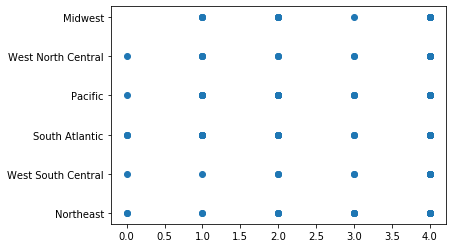

In [20]:
import matplotlib.pyplot as plt
plt.scatter(x=X_train_encoded['Main_Dish'], y=y_train)
plt.show();

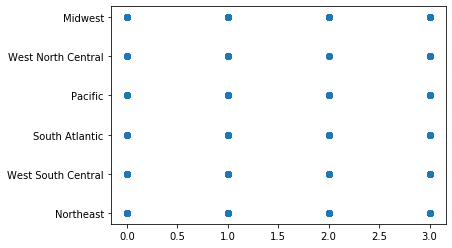

In [21]:
plt.scatter(x=X_train_encoded['Travel_Distance'], y=y_train)
plt.show();

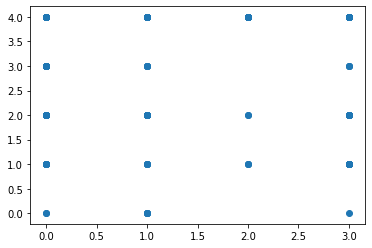

In [22]:
plt.scatter(x=X_train_encoded['Travel_Distance'], y=X_train_encoded['Main_Dish'])
plt.show();

In [23]:
#Logistic Regression Model

model = LogisticRegression(solver='lbfgs', max_iter = 10000, multi_class='auto')
model.fit(X_train_encoded, y_train)
loocv(X_train_encoded, y_train, model)
#26.6% accurate


Accuracy: 27.596% (44.700%)


In [ ]:
#Random Forest Model

classifier = RandomForestClassifier(n_estimators=100)
features = select_features(X_train_encoded, y_train, 10)
X_train_encoded_new = X_train_encoded[features]
classifier.fit(X_train_encoded_new, y_train)
loocv(X_train_encoded_new, y_train, classifier)
#22.2% accurate


Fitting estimator with 54 features.
Fitting estimator with 44 features.
Fitting estimator with 34 features.
Fitting estimator with 24 features.
Fitting estimator with 14 features.
10 selected features
['Main_Dish_Cooked', 'Prayer', 'Travel_Distance', 'Kids_Table_Age', 'Age', 'Gender', 'Number_Vegetables', 'Number_Starches', 'Number_Desserts', 'Number_Pies']


In [ ]:
#Randomized Search for hyperparameters


clf = RandomForestClassifier()

In [ ]:
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(results['mean_test_score'][candidate], results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [ ]:
# specify parameters and distributions to sample from
param_dist = {'max_depth': range(10, 50, 2),
              'min_samples_leaf': [1,2,3,4,5],'min_samples_split': [2, 3, 4, 5],
              'n_estimators': range(100, 500, 10),
              "criterion": ["gini", "entropy"]}

n_iter_search = 25
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=5, iid=False, n_jobs=-1)

random_search.fit(X_train_encoded, y_train)

report(random_search.cv_results_)

In [ ]:
#Grid Search for hyperparameters

param_grid = {"max_depth": range(30, 50, 5),
              "n_estimators": range(100, 500, 10),
              "min_samples_leaf": range(2, 5)
              }

# run grid search
grid_search = GridSearchCV(clf, param_grid=param_grid, cv=3, iid=False, n_jobs=-1)
grid_search.fit(X_train_encoded, y_train)
report(grid_search.cv_results_)

In [ ]:
#updated forest model 
classifier = RandomForestClassifier(n_estimators=250, min_samples_split = 4, min_samples_leaf=5, max_depth=12,
                                    criterion='gini')
features = select_features(X_train_encoded, y_train, 10)
X_train_encoded_new = X_train_encoded[features]
classifier.fit(X_train_encoded_new, y_train)
loocv(X_train_encoded_new, y_train, classifier)


In [ ]:
import xgboost
model = xgboost.XGBClassifier(n_jobs=-1)
model.fit(X_train_encoded, y_train)


loocv(X_train_encoded, y_train, model)

In [ ]:
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.svm import SVC

svc = SVC().fit(X_train_encoded, y_train)
perm = PermutationImportance(svc).fit(X_train_encoded, y_train)
eli5.show_weights(perm)

In [ ]:
X_train_encoded.iloc[:,7]

In [ ]:
X_train_encoded.iloc[:,8]

In [ ]:
import plotly_express as px

%matplotlib inline
px.scatter(train, x='Main_Dish', y='US_Region', color='Main_Dish_Cooked');

In [ ]:
px.scatter(train, x='Kids_Table_Age', y='US_Region', color='Main_Dish')

In [ ]:
px.scatter(train, 'Main_Dish', 'US_Region', facet_col='Main_Dish_Cooked', color='Gravy')

In [ ]:
from pdpbox.pdp import pdp_isolate, pdp_plot

In [ ]:
feature = 'Main_Dish'

isolated = pdp_isolate(
    model = model,
    dataset = X_train_encoded,
    model_features = X_train_encoded.columns,
    feature = feature
)

In [ ]:
import seaborn as sns
sns.set()

pdp_plot(isolated, feature_name=feature)

In [ ]:
pdp_plot(isolated, feature_name=feature, plot_lines=True, frac_to_plot=100)

In [ ]:
#creates pdp plot for each isolated item

for item in isolated:
    grid = item.feature_grids
    pdp = item.pdp
    lines = item.ice_lines.sample(100).T
    plt.plot(grid, pdp)
    plt.show()

In [ ]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot
#creates plot that shows interaction between two features
features=['Main_Dish','Main_Dish_Cooked']

interaction = pdp_interact(
    model=model,
    dataset=X_train_encoded,
    model_features=X_train_encoded.columns,
    features=features
)

In [ ]:
pdp_interact_plot(interaction, plot_type='grid', feature_names=features)

In [ ]:
for item in interaction: 
    pdp = item.pdp.pivot_table(
        values='preds',
        columns=features[0],
        index=features[1]
)
plt.figure(figsize=(10,6))
sns.heatmap(pdp, fmt=0)

In [ ]:
gb = model = xgboost.XGBClassifier(n_jobs=-1)
gb.fit(X_train_encoded, y_train)

In [ ]:
import matplotlib.pyplot as plt
from pdpbox import pdp

pdp_dist = pdp.pdp_isolate(model=gb, dataset=X_train_encoded, 
                           model_features=X_train_encoded.columns, feature='Main_Dish')
pdp.pdp_plot(pdp_dist, 'Main_Dish');

In [ ]:
import category_encoders as ce

X_train = train.drop('US_Region', axis=1)

encoder = ce.OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)

In [ ]:
encoder.mapping

In [1]:
for plot in pdp.pdp_plot(pdp_dist, 'Main_Dish'):
    plt.xticks([1,2,3,4,5], ['Turkey', 'Chicken', 'Tofurkey', 'Ham/Pork','Other'])


NameError: name 'pdp' is not defined

predict whether someone will have Turkey, Ham, or something else based on other items?

In [ ]:
train['Main_Dish'].unique()
train['Main_Dish'].value_counts(normalize=True)


In [ ]:
target = 'Main_Dish'
X_train_encoded, X_test_encoded, y_train, y_test = X_y_dataframes(train, test, target)

In [ ]:
classifier = RandomForestClassifier(n_estimators=100)
features = select_features(X_train_encoded, y_train, 10)
X_train_encoded = X_train_encoded[features]
classifier.fit(X_train_encoded, y_train)
loocv(X_train_encoded, y_train, classifier)

In [ ]:
food = ['Stuffing', 'Cranberry_Sauce', 'Gravy', 'Brussel_Sprouts', 'Carrots', 'Cauliflower',
       'Corn', 'Cornbread', 'Fruit_Salad', 'Green_Beans', 'Mac_and_Cheese',
       'Mashed_Potatoes', 'Rolls_Biscuits', 'Squash', 'Salad',
       'Sweet_Potatoes', 'Apple_Pie', 'Buttermilk_Pie', 'Cherry_Pie',
       'Chocolate_Pie', 'Coconut_Cream_Pie', 'Key_Lime_Pie', 'Peach_Pie',
       'Pecan_Pie', 'Pumpkin_Pie', 'Sweet_Potato_Pie', 'No_Pie',
       'Apple_Cobbler', 'Blondies', 'Brownies', 'Carrot_Cake', 'Cheesecake',
       'Cookies', 'Fudge', 'Ice_Cream', 'Peach_Cobbler']

In [ ]:
target = 'Main_Dish'
X_train_encoded, X_test_encoded, y_train, y_test = X_y_dataframes(train, test, target)
    

In [ ]:
#use only food columns for model
for column in X_train_encoded.columns:
    if column not in food:
        X_train_encoded = X_train_encoded.drop(column, axis=1)

In [ ]:
#logistic model
model = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter = 10000)
model.fit(X_train_encoded, y_train)
loocv(X_train_encoded, y_train, model)

In [ ]:
#Random Forest model
classifier = RandomForestClassifier(n_estimators=480, max_depth=45, min_samples_leaf=3)
features = select_features(X_train_encoded, y_train, 10)
X_train_encoded = X_train_encoded[features]
classifier.fit(X_train_encoded, y_train)
loocv(X_train_encoded, y_train, classifier)

In [ ]:
select_features(X_train_encoded, y_train, 10)

In [ ]:
X_train_encoded = X_train_encoded[features]

In [ ]:
classifier = RandomForestClassifier(n_estimators = 460, min_samples_split = 3, 
                                    min_samples_leaf = 5, max_depth = 40, criterion = 'entropy')
classifier.fit(X_train_encoded, y_train)
loocv(X_train_encoded, y_train, classifier)

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
y_pred_train = classifier.predict(X_train_encoded)
print(precision_recall_fscore_support(y_train, y_pred_train, average = 'weighted'))

In [ ]:
import xgboost
model = xgboost.XGBClassifier(n_jobs=-1)
model.fit(X_train_encoded, y_train)


loocv(X_train_encoded, y_train, model)

In [ ]:
gb = xgboost.XGBClassifier(n_estimators=200, objective='reg:squarederror', n_jobs=-1)

In [ ]:
gb.fit(X_train_encoded, y_train)